## Importing needed libraries

In [1]:
import numpy as np
import pandas as pd
import math
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline  
import glob
import random
from skimage.color import rgb2gray
from skimage.transform import rotate
import utilities as util
import importlib
importlib.reload(util)

<module 'utilities' from 'D:\\Noran\\Noran\\Third Year\\Second term\\NN\\Handwriting-Based-Gender-Classification\\Features (ipynb)\\utilities.py'>

## Functions needed

In [5]:
'''
Extract The start and end of each sequence of successive true values in the array.

params:
------
arr          np.array  boolean array containing false and true values

return:
-------
lines_start  np.array  array containing the start index of each sequence of true values.
lines_end    np.array  array containing the end index of each sequence of true values.

example:
-------

arr = np.array([True True False True True True False True False])
lines_start, lines_end = extract_successive_trues(arr)

>> lines_start
array([0 3 7])

>> lines_end
array([2 6 8])

'''
def extract_successive_trues(horiz_proj):
    processing_line = False
    lines_start = []
    lines_end = []

    for i in range(len(horiz_proj)):
        if(processing_line == True):
            if(horiz_proj[i] == False):
                lines_end.append(i)
                processing_line = False
        else:
            if(horiz_proj[i] == True):
                processing_line = True
                lines_start.append(i)
                
    # if the last element in arr was true
    if (len(lines_end) == len(lines_start) - 1):
        # Set the end of the last line as the last index of the array
        lines_end.append(len(horiz_proj))
        
    return lines_start, lines_end

In [6]:
'''
Extract lines from a handwritten image.

params:
-------
img                   np.arrray()   Image to extract lines from.
margin_top            float         How many pixels above the extracted line to consider.
margin_bottom         float         How many pixels below the extracted line to consider.
avg_thickness_perc    float         The percentage of the average thickness below which to discard a line.
verbose               boolean       If true show a visualization of the lines extracted. By default: False.

returns:
-------
lines                 list          List of images, each image holds a line extracted from the original image. Each image is an np.array.
'''
def extract_lines(img, margin_top=30, margin_bottom=15, avg_thickness_perc = 0.5, verbose=False):
    
    # Sum across the horizontal axis i.e across the text lines
    horiz_proj = np.sum(img, axis=1)
    
    # Calculating the threshold between having text (a line) or having white spacing between lines
    avg = np.average(horiz_proj)
    margin = (np.max(horiz_proj)-avg)/3
    thres = avg + margin
    
    if (verbose):
        # Rotate image by 90 degrees
        img_90 = rotate(img, 90, resize=True)
        # Plot the lines' summation values
        plt.plot(range(0,len(horiz_proj)),horiz_proj) 
        
        plt.axhline(y=thres, color='r', linestyle='-')
        plt.imshow(img_90, cmap='gray')
        plt.show()
    
    # Extract Lines start index and end index
    lines_start, lines_end = extract_successive_trues(horiz_proj < thres)
    lines = []
    lines_thickness = []

    # Discard noisy lines - lines with thickness smaller than 10 pixels
    for i in range(len(lines_start)):
        line_thickness = lines_end[i] - lines_start[i]
        if (line_thickness > 10):
            lines_thickness.append(line_thickness)  

    # Estimate the average thickness of filtered lines (for Lines > 10 pixels)
    lines_thickness = np.array([lines_thickness])
    avg_thickness = np.average(lines_thickness)
    
    lines_thickness = []
    # Extract the lines from the image
    for i in range(len(lines_start)):
        # Add margines to the lines starting and ending indices
        if (lines_start[i] - margin_top > 0):
            line_top = lines_start[i] - margin_top
        else:
            line_top = 0
        if (lines_end[i] + margin_bottom < len(horiz_proj)):
            line_bottom = lines_end[i] + margin_bottom
        else:
            line_bottom = len(horiz_proj) - 1

        line_thickness = lines_end[i] - lines_start[i]
        # Discard noisy lines - lines with thickness smaller than 0.5 of the average thicknesses (default)
        if (line_thickness > avg_thickness_perc*avg_thickness):
            lines_thickness.append(line_thickness)
            lines.append(img[line_top:line_bottom, :])
            if (verbose):
                util.show_image(img[line_top:line_bottom, :]*255)
                print('--------')

    if (verbose):
        print("lines' thickness array: ", lines_thickness)
        print('avg thickness of this paper: ', avg_thickness)
        print('discard lines thiner than: ', avg_thickness*avg_thickness_perc)
        print("final lines' thickness array: ", lines_thickness)

    return lines

In [7]:
'''
Removing white space margins from the left and right endings of a handwritten line.

params:
-------
lines               list     List of images, each image is a np.array representing a handwritten line.

noise_margin_perc   float    Percentage of the degree of white (1.0) to consider as a margin. 
                             Margin is not considered to be 100% white in order to account for errors in the binary image due to illumination and camera effects.

verbose             boolean  If true show a visualization of the cropped lines. By default: False.

return:
------
cropped_lines       list     List of images, each image is a line cropped from of its left and right white margins.

'''
def cut_white_margins(lines, noise_margin_perc = 0.95, verbose=False):
    cropped_lines = []
    
    for i in range(len(lines)):
        
        # Project the line vertically
        vert_proj = np.sum(lines[i], axis=0)
        # Get line thickness in pixels
        line_thickness = lines[i].shape[0]

        # Cut the start and end of the projection array
        # Cut from the start going to right till a threshold is violated
        # Cut from the end going to the left till a threshold is violated
        # Threshold is set to account for lighting effects in the binary thresholding.
        vert_proj = vert_proj <= line_thickness*noise_margin_perc
        
        # Finding the end of the line's left white-margin
        end_of_left_margin = 0
        while(end_of_left_margin < len(vert_proj) and (not vert_proj[end_of_left_margin])):
            end_of_left_margin += 1

        # Finding the start of the line's right white-margin
        start_of_right_margin = len(vert_proj) - 1
        while(start_of_right_margin > 0 and (not vert_proj[start_of_right_margin])):
            start_of_right_margin -= 1

        # Remove left and right White-margins from the line
        cropped_line = lines[i][:, end_of_left_margin:start_of_right_margin]
        cropped_lines.append(cropped_line)
        
        # Visualize the line with the projection result
        if (verbose):
            plt.imshow(lines[i])
            plt.axvline(x=start_of_right_margin, color='b', linestyle='-')
            plt.axvline(x=end_of_left_margin, color='b', linestyle='-')
            plt.show()
            
    return cropped_lines

In [8]:
'''
Remove large continous white spaces. Large with respect to the image width.

params:
------
lines                list    array of images, each image is a line to remove the big white-pixeled spaces from.
white_space_thresh   float   percentage of image's width to consider any continous white pixels above as large white pixels.

return:
-------
cleaned_lines        list    array of lines after removing redundant large white-spaces from.
'''
def remove_large_white_space(lines, white_space_thresh=0.25):
    cleaned_lines = []
    for i in range(len(lines)):
        ver_proj = np.sum(lines[i], axis=0)
        line_height, line_width = lines[i].shape

        words_start, words_end = extract_successive_trues(ver_proj>0.9*line_height)
        # Discard noisy white spaces
        # By finding white space greater than the quarter of the line width
        white_space_counts = len(words_start)
        j = 0
        while(j < white_space_counts and (words_end[j]-words_start[j]) < white_space_thresh*line_width):
            j += 1
        
        if(j<white_space_counts):
            # if line endings have big white space, cut it before the white space
            cleaned_lines.append(lines[i][:,:words_start[j]])
        else:
            # if no big intermediate white space, leave line as is
            cleaned_lines.append(lines[i])
    return cleaned_lines

In [9]:
'''
Calculate avg % of white pixels for the lines in an image.

params:
------
lines     list      list of images, each image is a handwritten-text line.
verbose   boolean   If true show a visualization of the image before and after cleaning. By default: False.

'''

def calc_space_percentage(lines, verbose=False):
    avg_space_perc = 0
    lines_count = len(lines)
    for i in range(lines_count):
        proj = np.sum(lines[i], axis=0)

        # Calculate the % of white pixels (spaces) in the line
        space_perc = np.mean(lines[i])
        avg_space_perc += space_perc
        
        if (verbose):
            plt.plot(range(0,len(proj)), proj) 
            util.show_image(lines[i]*255)
            print(space_perc*100)

    # For white empty images
    if lines_count == 0:
        print('empty image')
        return 1.0
    
    avg_space_perc /= lines_count
    return avg_space_perc

In [10]:
'''
Calculate avg % of white pixels for the lines in an image.

params:
------
img       np.array    Handwritten-text image to calculate the % of white pixels for its lines.
verbose   boolean     If true show a visualization of the image before and after cleaning. By default: False.
'''
def calc_space_feature(img, verbose=False):
    lines = extract_lines(img=img, verbose=verbose)
    lines = cut_white_margins(lines=lines, noise_margin_perc=0.9, verbose=verbose)
#     lines = remove_large_white_space(lines=lines)
    avg_space_perc = calc_space_percentage(lines=lines, verbose=verbose)
    
    return avg_space_perc

## Read Sample of images

Females handwritten samples


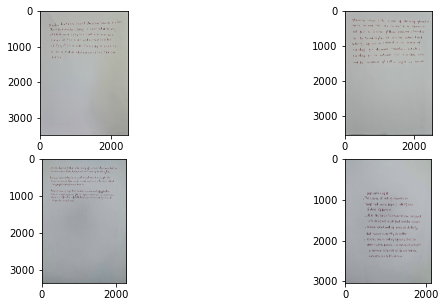

Males handwritten samples


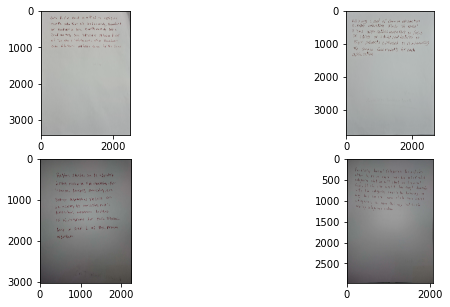

In [3]:
# Read the test images
female_imgs = util.read_imgs('../data/Females')
male_imgs = util.read_imgs('../data/Males')


# Preview 9 samples
print('Females handwritten samples')
util.draw_grid(figsize=(10,5), rows=2, cols=2, imgs=female_imgs[:4])
print('Males handwritten samples')
util.draw_grid(figsize=(10,5), rows=2, cols=2, imgs=male_imgs[:4])

### Images Preprocessing and Space Feature Calculation
#### Labels notation
- 0 for males
- 1 for females

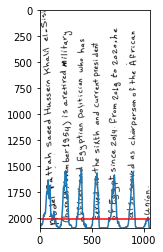

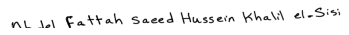

--------


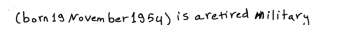

--------


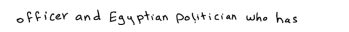

--------


--------


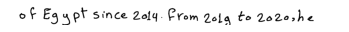

--------


--------
lines' thickness array:  [85, 66, 67, 52, 70, 60]
avg thickness of this paper:  59.42857142857143
discard lines thiner than:  29.714285714285715
final lines' thickness array:  [85, 66, 67, 52, 70, 60]


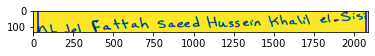

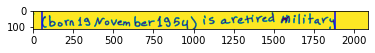

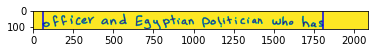

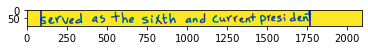

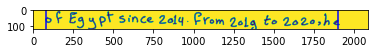

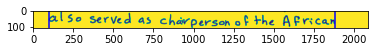

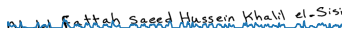

91.46364388299872


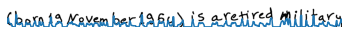

88.337052197085


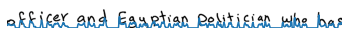

89.99539500613999


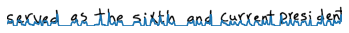

87.90300324426428


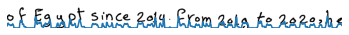

89.44997380827658


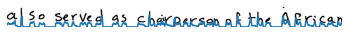

89.44738389182834


NameError: name 'female_paths' is not defined

In [11]:

# Binary Thresholding and Text Area Extraction on all images
females_count = len(female_imgs)
males_count = len(male_imgs)

data = []
# Calculating features for females' images
for i in range(females_count):
    # Binary Thresholding the image to only 0 and 255
    img = util.threshold_image(female_imgs[i])
    img = util.extract_textarea(img)
    # Normalize the image
    img=img/255
    space_value = calc_space_feature(img=img, verbose=True)
    # only add the non-empty images to the dataframe
    # space_value = 1.0 means no lines exists, i.e all image is white space.
    if math.isnan(space_value):
        print('nan: ')
        print(female_paths[i])
    if space_value != 1.0:
        data.append([female_paths[i], space_value, 1])
    break
    
# Calculating features for males' images
for i in range(males_count):
    # Binary Thresholding the image to only 0 and 255
    img = util.threshold_image(male_imgs[i])
    img = util.extract_textarea(img)
    # Normalize the image
    img=img/255
    space_value = calc_space_feature(img=img)
    if space_value != 1.0:
        data.append([male_paths[i], space_value, 0])
    
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['img_path', 'space_ratio', 'gender'])

## Calculate % of white spaces in text

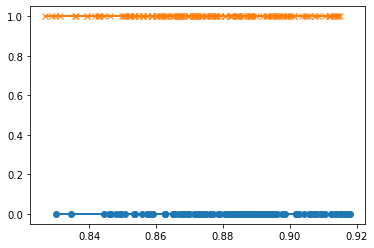

In [65]:
male_spaces = df[df['gender'] == '0']['space_ratio']
female_spaces = df[df['gender'] == '1']['space_ratio']

plt.plot(male_spaces.values, np.zeros(np.shape(male_spaces)[0]), marker = "o")
plt.plot(female_spaces.values, np.zeros(np.shape(female_spaces)[0])+1, marker = "x")
plt.show()

#### Comment:
No clear distinction between male and female in the space ratio of their handwritting

In [77]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(df.space_ratio.values.reshape((-1,1)), df.gender, test_size=0.3,random_state=109) 

clf = svm.SVC(kernel='rbf') 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.42105263157894735
